# Point Quadtree
Source: [Coding Challenge #98.1: Quadtree - Part 1 by "The Coding Train"](https://www.youtube.com/watch?v=OJxEcs0w_kE)

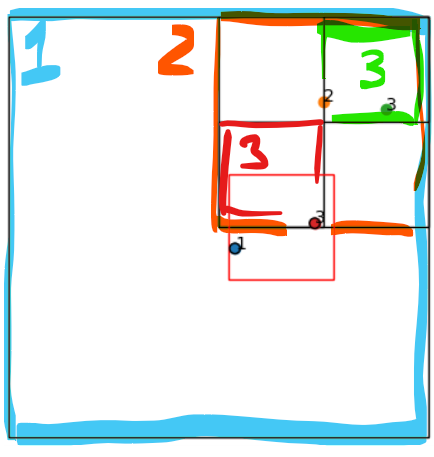

Quad tree is a 2D data storage structure that allows to perform faster neighbor search than each-to-each comparison (Complexity $\mathcal{O}(n^2)$). For a single entry search complexity is $\mathcal{O}(\log{n})$ or  $\mathcal{O}(n \log{n})$ for n entries.

Quad tree consists of rectangle (geometric) bins, which have capacity to hold N points inside. When capacity is reached, bins are subdevided into 4 (quad) smaller bins, which are filled considering in same geometric fashion. 

Search of nearest neighbors is multiscale (biggest bins first) and is based on search region-and-bin geometric intersection.

Notice that because bins have capacity, stored points will overlap lower level bins. 

In [1]:
import numpy as np
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt

class Point():
    def __init__(self, x, y):
        self.x = x
        self.y = y

class Box():
    def __init__(self, cx, cy, w, h):
        self.x = cx
        self.y = cy
        self.w = w
        self.h = h
        self.storage = []
        self.x0 = cx-w/2
        self.y0 = cy-h/2
        self.xywh_corner = (self.x0 , self.y0, w, h)
        self.xywh = (cx, cy, w, h)

    def xy_corners(self):
        x0 = self.x0
        y0 = self.y0 
        w = self.w 
        h = self.h
        return [(x0, y0), (x0 + w, y0), (x0 + w, y0 + h), (x0, y0 + h)]
    
    def corner_points(self):
        return [Point(*xy) for xy in self.xy_corners()]
    
    def contains(self, point: Point, debug = False):
        x = point.x
        y = point.y

        contains = (    (self.x - self.w/2 < x < self.x + self.w/2) 
                and (self.y - self.h/2 < y < self.y + self.h/2))
        if debug :print(f'point (x,y)={(x,y)}, region: x:{self.x - self.w/2}->{self.x + self.w/2}; y: {self.y - self.h/2}->{self.y + self.h/2} contains: {contains}')
        return contains
    
    def intersects(self, region: 'Box'):
        """
            check intersection of two retions this must include cases of regions within regions.
            can do it by checking region corner points inside self and other way around.
        """
        self_pts_in_reg = [region.contains(p)   for p in self.corner_points()]
        reg_pts_in_self = [self.contains(p)     for p in region.corner_points()]

        return any(self_pts_in_reg) or any(reg_pts_in_self)
    

class QuadTree():
    def __init__(self, bounding_box, capacity):
        self.boundary = bounding_box
        self.capacity = capacity
        self.points = []
        self.devided = False

    def subdivide(self):

        x, y, w, h = self.boundary.xywh

        nw = Box(x - w/4, y - h/4, w/2, h/2)
        ne = Box(x + w/4, y - h/4, w/2, h/2)
        sw = Box(x - w/4, y + h/4, w/2, h/2)
        se = Box(x + w/4, y + h/4, w/2, h/2)

        self.nw = QuadTree(nw, self.capacity)
        self.ne = QuadTree(ne, self.capacity)
        self.sw = QuadTree(sw, self.capacity)
        self.se = QuadTree(se, self.capacity)

        self.devided = True
    
    def insert(self, point: Point):
        if self.boundary.contains(point):
            if len(self.points) < self.capacity:
                self.points.append(point)
            else:
                if not self.devided:
                    self.subdivide()
            
                self.nw.insert(point)
                self.ne.insert(point)
                self.sw.insert(point)
                self.se.insert(point)


    def search_points(self, region: Box):
        # top level has no points-> nothing to search.
        # or if points, but does not intersect -> dont search
        has_points = len(self.points) > 0
        intersects = self.boundary.intersects(region)
        if not has_points or not intersects:
            return
        # check if points stored in top level of this quad are in region
        for p in self.points:
            if region.contains(p):
                region.storage.append(p)
        # check deeper levels
        if self.devided:
            self.nw.search_points(region)
            self.ne.search_points(region)
            self.sw.search_points(region)
            self.se.search_points(region)


    def show(self, ax, set_lims = False, region = None, layer = None):
        
        if len(self.points)>0:

            x,y,w,h = self.boundary.xywh_corner
            patch = Rectangle((x, y), w, h, linewidth = 1, fill = False, fc = 'none')
            ax.add_patch(patch)
            
            for p in self.points:
                plt.scatter([p.x],[p.y])
                if layer is not None:
                    plt.annotate(str(layer), (p.x, p.y))

            if self.devided:
                t = None if layer is None else layer + 1
                self.nw.show(ax, layer= t)
                self.ne.show(ax, layer= t)
                self.sw.show(ax, layer= t)
                self.se.show(ax, layer= t)  

            if set_lims:
                x,y,w,h = self.boundary.xywh
                ax.set_xlim(x - w/2 - w/20, x + w/2 + w/20)
                ax.set_ylim(y - h/2 - h/20, y + h/2 + h/20)
                ax.invert_yaxis()   # matrix indexing

            if region is not None:
                x,y,w,h = region.xywh_corner
                ax.add_patch(Rectangle((x,y), w, h, linewidth = 1, fill = False, fc = 'none', edgecolor='r'))
                for p in region.storage:
                    plt.scatter([p.x],[p.y], fc='none', edgecolors='k', linewidths= 1)#, markeredgewidth=5

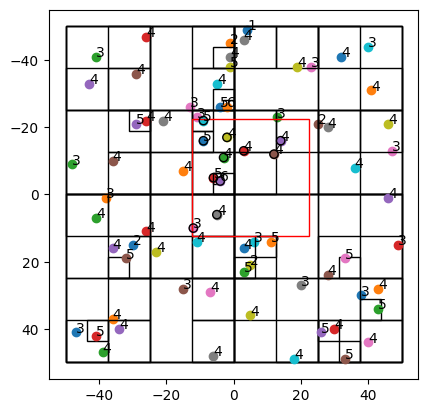

In [3]:
np.random.seed(69)
fig, ax = plt.subplots(1)
ax.set_aspect('equal')
cap = 1

num_points = 84
if 1==1:
    w = 100
    h = 100
    x = 0
    y = 0
    points_xy = np.array([     np.random.randint(-w/2,w/2, size = num_points),
                            np.random.randint(-h/2,h/2, size = num_points)]).T
else:
    mean = (0, 0)  # Mean of the distribution
    cov_matrix = np.diag((180,180))  # Covariance matrix
    points_xy = np.random.multivariate_normal(mean, cov_matrix, size=num_points)

    x_min, y_min = np.min(points_xy,axis=0)
    x_max, y_max = np.max(points_xy,axis=0)

    w = (x_max - x_min)
    h = (y_max - y_min)

    x = x_min + 0.5*w
    y = y_min + 0.5*h

#print(points_xy)#[:3])
points = [Point(*p) for p in points_xy]

bounding_box = Box(x,y,w,h)
quad = QuadTree(bounding_box, cap)

for p in points:
    quad.insert(p)

search_reg = Box(5,-5,35,35)
quad.search_points(search_reg)
quad.show(ax, set_lims=True, region=search_reg, layer=1)
